# Zobrazení mapových vrstev z geodatabáze

Tento notebook slouží k zobrazení a analýze mapových vrstev uložených v GeoPackage databázi.

In [4]:
# Importy potřebných knihoven
import geopandas as gpd
import matplotlib.pyplot as plt
from sqlalchemy import create_engine
import yaml
import os
import sys
import fiona



# Přidání nadřazeného adresáře do cesty, aby bylo možné importovat modul mnd_spi_app
# (upravte cestu, pokud je notebook umístěn jinde)
notebook_dir = os.getcwd() 
project_dir = os.path.abspath(os.path.join(notebook_dir, '..', '..', '..'))
if project_dir not in sys.path:
    sys.path.append(project_dir)

print(notebook_dir)
print(project_dir)

c:\spaces\pythons\mnd_spi_app\data\SLP_VYVOJ\notebooks
c:\spaces\pythons\mnd_spi_app


## Konfigurace a inicializace

Nastavení cest k GeoPackage a SQLite databázi.

In [9]:
# Cesty k databázím
konfigurace = 'slp_vyvoj'

# Načtení konfigurace
with open(os.path.join(project_dir, 'konfigurace', konfigurace+'.yaml'), encoding="utf-8") as f:
    lhc_config = yaml.safe_load(f)
with open(os.path.join(project_dir, 'konfigurace', konfigurace+'_uid.yaml'), encoding="utf-8") as f:
    uid_config = yaml.safe_load(f)
# Kontrola existence souborů

# Vytvoření připojení k PostgreSQL
pg_engine = create_engine(
    f"postgresql://{lhc_config['db_config']['postgres_user']}:"
    f"{lhc_config['db_config']['postgres_password']}@"
    f"{lhc_config['db_config']['postgres_host']}:"
    f"{lhc_config['db_config']['postgres_port']}/"
    f"{lhc_config['db_config']['postgres_db']}"
)

## Načtení dat z PostgreSQL
### Hranice celého LHP

In [13]:
gdf_lhp_all = gpd.read_postgis(
    f"SELECT ggeom_all as geom FROM happ.lhp WHERE uid = '{uid_config['uid_lhp']}'",
    pg_engine
)

### Hranice porostní půdy (pro extent)

In [14]:
gdf_lhp_ps = gpd.read_postgis(
    f"SELECT ggeom_ps as geom FROM happ.lhp WHERE uid = '{uid_config['uid_lhp']}'",
    pg_engine
)

### Výběrová strata

In [17]:
gdf_vs = gpd.read_postgis(
    f"""
    SELECT vs.stratum, vs.ggeom as geom 
    FROM dsuhul.vs vs 
    WHERE vs.uid_firm = '{uid_config['uid_firm']}' AND vs.uid_lhc = '{uid_config['uid_lhc']}'
    """,
    pg_engine
)

### Vytvoření mapy

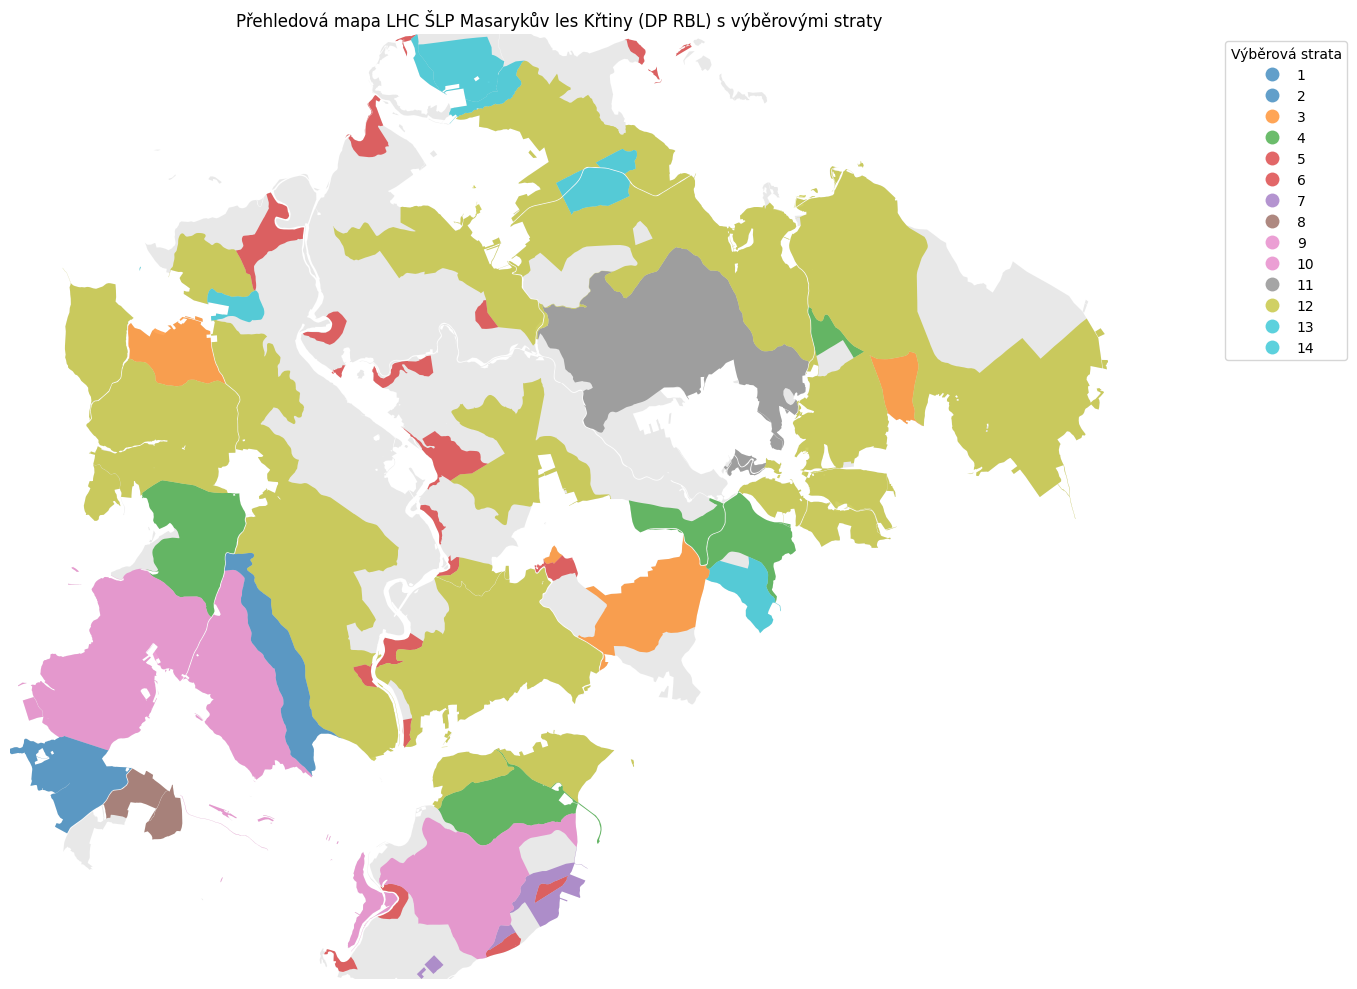

In [22]:
fig, ax = plt.subplots(figsize=(15, 10))

# Vykreslení hranice LHP (šedá)
gdf_lhp_all.plot(ax=ax, color='lightgrey', alpha=0.5)

# Vykreslení výběrových strat s legendou
gdf_vs.plot(
    ax=ax,
    column='stratum',
    legend=True,
    legend_kwds={
        'title': 'Výběrová strata',
        'bbox_to_anchor': (1.1, 1),
        'loc': 'upper left',
        'labels': sorted([str(x) for x in gdf_vs['stratum'].unique()], key=int)
    },
    alpha=0.7
)

# Nastavení rozsahu mapy podle porostní půdy
ax.set_xlim([gdf_lhp_ps.total_bounds[0], gdf_lhp_ps.total_bounds[2]])
ax.set_ylim([gdf_lhp_ps.total_bounds[1], gdf_lhp_ps.total_bounds[3]])

# Přidání nadpisu
plt.title(f"Přehledová mapa LHC {lhc_config['nazev']} s výběrovými straty")

# Odstranění os
ax.set_axis_off()

plt.tight_layout()
plt.show()